# Sta 663 Final Project 


In [5]:
import scipy.stats as stats
import random
import numpy as np
import pandas as pd
import numpy.linalg as la
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from sklearn import linear_model
import datetime
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
sns.set_context("notebook", font_scale=1.5)
#%matplotlib inline

In [21]:
np.random.seed(147)

** Leapfrog **

This code is based on the fact that kinetic energy is $K(p) = \sum_{i=1}^n p_i^2$, i,e. all $m_i$=1

In [19]:
def leapfrog(U, grad_U, current_q, Sigma, stepsize=0.25, steps=25):
    '''
    Performs the leapfrog algorithm for HMC, with 1 accept/reject step
    '''
    
    q = current_q
    p = np.random.normal(0,1,q.size) # independent statndard normal variates
    current_p = p
    q_list=q
    p_list=p
    
    # Half step for momentum at the beginning
    p = p - stepsize*grad_U(q,Sigma)/2
    
    # Alternate full steps for position and momentum
    for i in range(steps):
        
        # Make a full step for the position
        q = q + stepsize*p
        q_list = np.vstack((q_list,q))
        
        # Make a full step for the momentum, except at end of trajectory
        if (i!=steps-1):
            p = p - stepsize*grad_U(q,Sigma)
            p_list = np.vstack((p_list,p))
    
    # Make a half step for momentum at the end
    p = p - stepsize*grad_U(q,Sigma)/2
    p_list = np.vstack((p_list,p))
    
    # Negate momentum at end of trajectory to make the proposal symmetric
    p = -p
    
    # Evaluate potential and kinetic energies at start and end of trajectory
    current_U = U(current_q,Sigma)
    current_K = sum(current_p**2)/2
    proposed_U = U(q,Sigma)
    proposed_K = sum(p**2)/2

    # Accept or reject the state at end of trajectory, returning either the postion at the end
    # of the trajectory or the initial position
    if (np.random.uniform(0,1) < np.exp(current_U-proposed_U+current_K-proposed_K)):
        return(q,p_list,q_list) # Accept
    else:
        return(current_q,p_list,q_list) # Reject
    

**Potential energy and gradient**

In [20]:
def U(q,Sigma):
    '''
    Returns -log p(q)
    '''
    return (-np.log(stats.multivariate_normal.pdf(q, mean=np.zeros(q.size), cov = Sigma)))

def grad_U(q,Sigma):
    '''
    The partial of U(q) with respect to U.
    In our case, U(q) = q^T(Sigma^{-1})q/2, so the partial is q^T(Sigma^{-1})
    '''
    
    return(np.dot(q,la.inv(Sigma)))

**Running the function**

In [22]:
current_q = np.array([-1.5,-1.55])
Sigma2 = np.array([[1, 0.95],[0.95,1]]) #Correlations of .95 between the two variables
q,p_list,q_list=leapfrog(U, grad_U, current_q, Sigma = Sigma2, stepsize=0.25, steps=25)

**Corresponding HMC values**

In [23]:
Hamiltonian_value = np.zeros(26)
for i in range(26):
    Hamiltonian_value[i] = U(q_list[i,:],Sigma2)+ np.dot(p_list[i,:].T,p_list[i,:])/2

**Illustration of HMC paths**

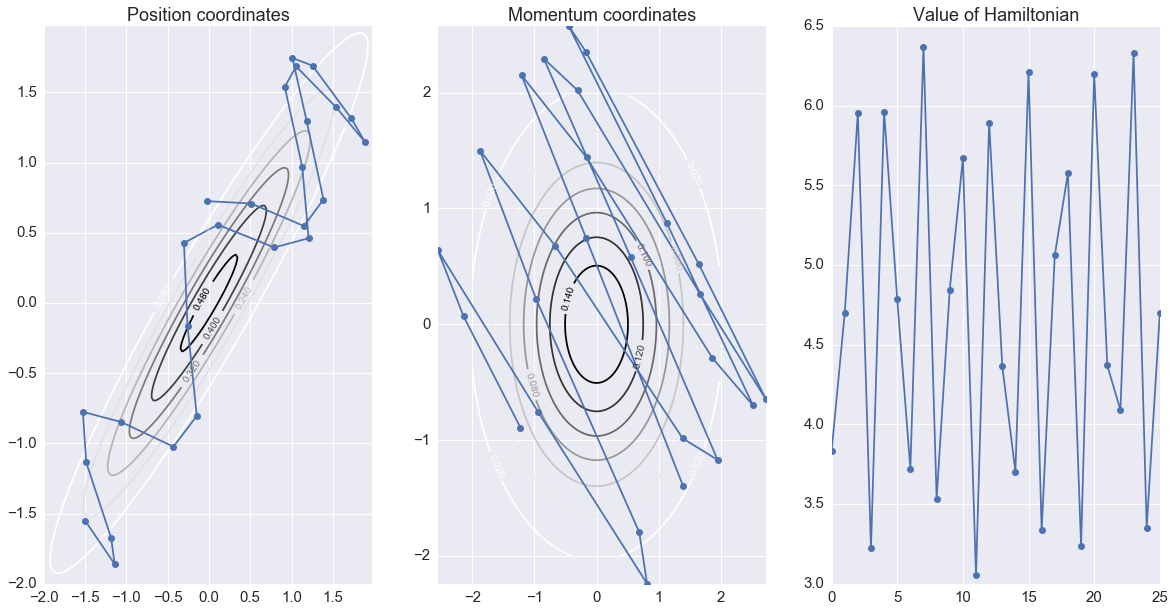

In [7]:
#Setting up the grid to plot over
delta = 0.025
x = np.arange(-2.0, 2.0, delta)
y = np.arange(-2.0, 2.0, delta)
X, Y = np.meshgrid(x, y)
plt.figure(figsize=(20,10))

#Ploting the position coordinates for the 25 leapfrog steps
plt.subplot(131)
Z = mlab.bivariate_normal(X, Y, 1.0, 1.0, 0.0, 0.0,0.95)
CS = plt.contour(X, Y, Z)
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Position coordinates')
plt.plot(q_list[:,0], q_list[:,1], '-o')

#Plotting the momentum coordinates for the 25 leapfrog steps
plt.subplot(132)
Z = mlab.bivariate_normal(X, Y, 1.0, 1.0, 0.0, 0.0)
CS = plt.contour(X, Y, Z)
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Momentum coordinates')
plt.plot(p_list[:,0], p_list[:,1], '-o')

#Plotting the Hamiltonian
plt.subplot(133)
plt.plot(np.arange(Hamiltonian_value.size), Hamiltonian_value, '-o')
plt.title('Value of Hamiltonian')
plt.savefig("HMC_eg.png")

**Critical stepsize**


At a critical stepsize the trajectory becomes unstable and the value of Hamiltonian grows without bound. Here we can see the critical stepsize is somewhere close to 0.35

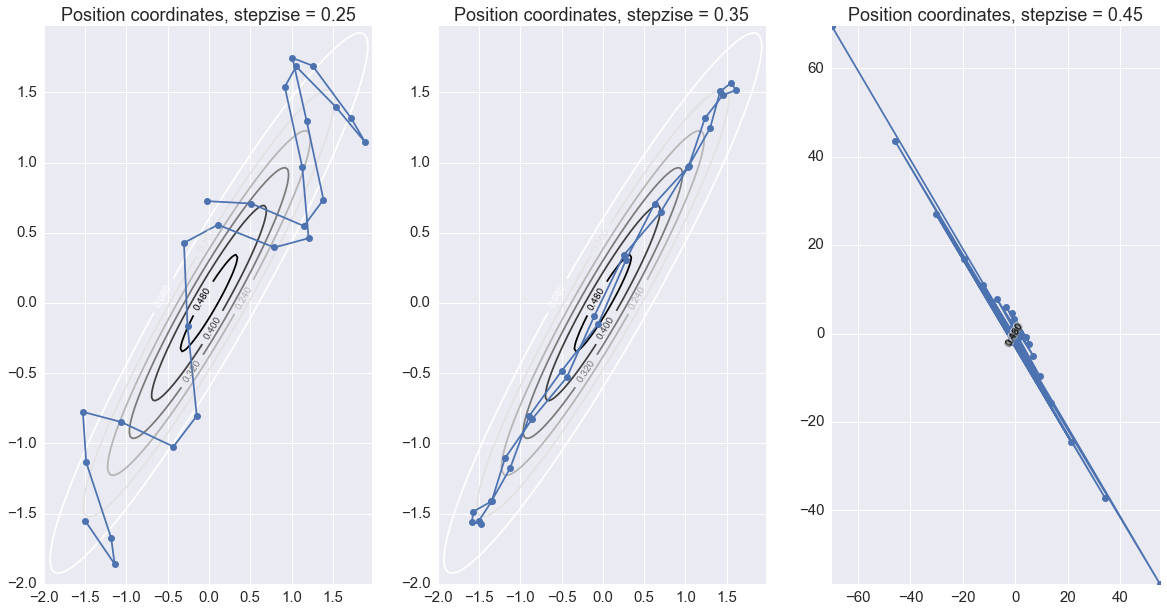

In [8]:
#Getting the leapfrog steps for the larger stepsizes
current_q = np.array([-1.5,-1.55])
q1,p1_list,q1_list=leapfrog(U, grad_U, current_q, Sigma2, stepsize=0.35, steps=25)
current_q = np.array([-1.5,-1.55])
q2,p2_list,q2_list=leapfrog(U, grad_U, current_q, Sigma2, stepsize=0.45, steps=25)

#Plotting 
plt.figure(figsize=(20,10))

#Stepsize of 0.25 as before
plt.subplot(131)
Z = mlab.bivariate_normal(X, Y, 1.0, 1.0, 0.0, 0.0,0.95)
CS = plt.contour(X, Y, Z)
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Position coordinates, stepzise = 0.25')
plt.plot(q_list[:,0], q_list[:,1], '-o')

#Stepsize 0.35 - still traverses the space
plt.subplot(132)
Z = mlab.bivariate_normal(X, Y, 1.0, 1.0, 0.0, 0.0,0.95)
CS = plt.contour(X, Y, Z)
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Position coordinates, stepzise = 0.35')
plt.plot(q1_list[:,0], q1_list[:,1], '-o')

#Stepsize 0.45 - too large, with clearly unstable position variable
plt.subplot(133)
Z = mlab.bivariate_normal(X, Y, 1.0, 1.0, 0.0, 0.0,0.95)
CS = plt.contour(X, Y, Z)
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Position coordinates, stepzise = 0.45')
plt.plot(q2_list[:,0], q2_list[:,1], '-o')
plt.savefig("HMC_critical_stepsize.png")

# MH vs HMC in 2D

200 iterations of the HMC(with 20 Leapfrog steps per trajectory) for a 2D Gaussian distribution with marginal standard deviations of 1 and correlation 0.98.

**HMC**

In [21]:
def HMC(U, grad_U, current_q, Sigma, stepsize=0.2, steps=25, max_iter= 20, step_range=0):
    '''
    Performs max_iter iterations of HMC with leapfrog discritization method
    To randomize stepsize, set step_range to be nonzero
    '''
    
    current_q_list = current_q
    
    for i in range(max_iter):
        
        #Randomize stepsize if called for
        #Note if step_range = 0, it just draws stepsize
        stepsize_r = np.random.uniform(stepsize-step_range,stepsize+step_range)

        #Keep the position variable after every itertion
        current_q,p_list,q_list = leapfrog(U, grad_U, current_q, Sigma, stepsize_r, steps)
        current_q_list = np.vstack((current_q_list,current_q))
    return(current_q_list[:-1,:])

**Running the HMC**

In [24]:
Sigma2_high_cor = np.array([[1, 0.98],[0.98,1]])
current_q2 = np.array([-1.5,-1.55])
hmc_output_2d=HMC(U, grad_U, current_q2, Sigma2_high_cor, stepsize=0.18, steps=20, max_iter=200)

**MH**

In [10]:
def metropolis_multigaus(target,proposal,thin,niters,dim):
    '''
    Metropolis algorithm. Flexible for target/proposal distributions, as well as dimensionality
    Thins the chain to avoid autocorrelation
    '''
    post = np.zeros((niters,dim))
    current = proposal.rvs()
    accept = 0
    for i in range(thin*niters):
        #Proposed value
        post_p = current + proposal.rvs() #Assumes proposal.rvs is centered at zero
        
        #Probability of acceptance
        rho = min(1, target.pdf(post_p)/target.pdf(current))
        u = np.random.uniform()
        
        #Accept step
        if u < rho:
            accept += 1
            current = post_p
            
        #Only add to return list if i is a multiple of thin
        if i % thin < 1:
            post[i//thin,:] = current
    return(post,accept/(niters*thin))

**Running the MH**

In [25]:
#Target mean. Note Covariance matrix is alredy defined as Sigma2_high_cor
mu = np.array([0,0])

mu_prop = np.array([0,0])
cov_prop = (np.array([[.18**2,0],[0,.18**2]]))
target2d = stats.multivariate_normal(mu,Sigma2_high_cor)
proposal2d = stats.multivariate_normal(mu_prop,cov_prop)

#Getting the output for metropolis
mh_output_2d, mh_2d_ratio = metropolis_multigaus(target2d,proposal2d,20,200,2)

**Comparing the first 20 iterations of MH vs HMC**

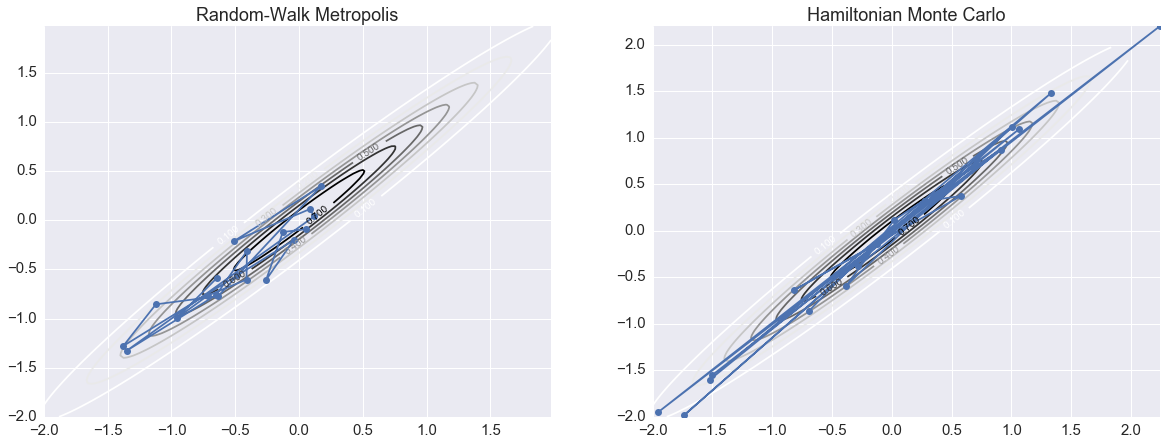

In [13]:
#Setting up the plotting grid
delta = 0.025
x = np.arange(-2.0, 2.0, delta)
y = np.arange(-2.0, 2.0, delta)
X, Y = np.meshgrid(x, y)
plt.figure(figsize=(20,7))

#Metropolis iterations. Does not cover whole space in this time
plt.subplot(121)
Z = mlab.bivariate_normal(X, Y, 1.0, 1.0, 0.0, 0.0,0.98)
CS = plt.contour(X, Y, Z)
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Random-Walk Metropolis')
plt.plot(mh_output_2d[0:19,0],mh_output_2d[0:19,1], '-o')

#HMC iterations. Does a much better job covering the whole target space
plt.subplot(122)
Z = mlab.bivariate_normal(X, Y, 1.0, 1.0, 0.0, 0.0,0.98)
CS = plt.contour(X, Y, Z)
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Hamiltonian Monte Carlo')
plt.plot(hmc_output_2d[0:20:,0], hmc_output_2d[0:20:,1], '-o')

plt.savefig("MH_HMC_double_position.png")

**Comparing all 200 iterations for the first element**

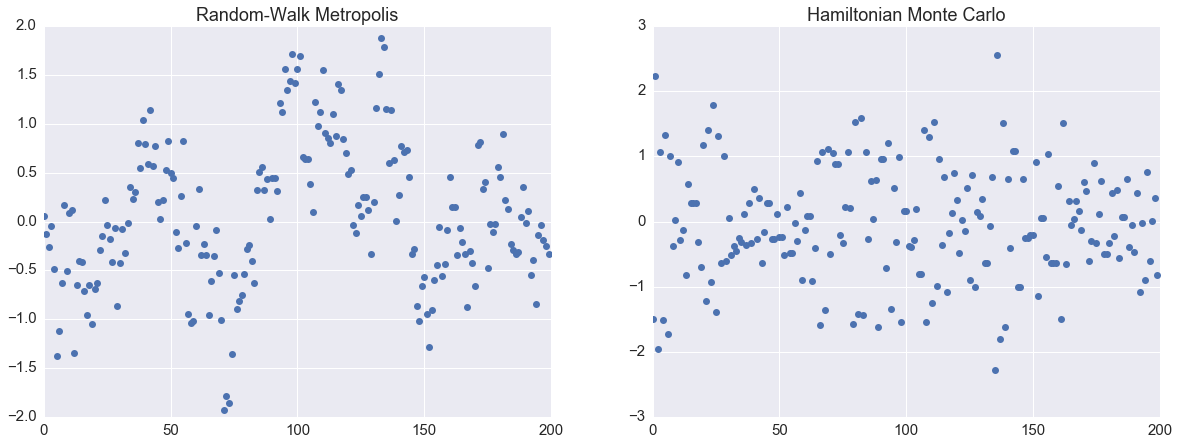

In [14]:
plt.figure(figsize=(20,7))

#Metropolis itertions - note the autocorrelation, even with thinning
#This is a consequence of the high correlation between variables
plt.subplot(121)
plt.plot(range(len(hmc_output_2d[:,0])),mh_output_2d[:,0], 'o')
plt.title('Random-Walk Metropolis')

#HMC iterations - much less autocorrelation, explores the space well
plt.subplot(122)
plt.title('Hamiltonian Monte Carlo')
plt.plot(range(len(hmc_output_2d[:,0])), hmc_output_2d[:,0], 'o')

plt.savefig("MH_HMC_single_position.png")

# MH vs MHC in High Dimension

**MH**

In [26]:
#Multivariate Normal target distribution parameters
mu_100 = np.zeros(100)
cov_100 = np.diag([(i/100)**2 for i in range(1,101)])

#Metropolis proposal parameters
mu_prop100 = np.zeros(100)
cov_prop100 = np.diag(np.repeat(stats.uniform.rvs(0.0176,0.0264)**2,100)) #Standard dev. as suggested by Neal
target_100d = stats.multivariate_normal(mu_100,cov_100)
proposal_100d = stats.multivariate_normal(mu_prop100,cov_prop100)

In [27]:
#Running Metropolis, keeping the mean and standard deviation of each variable
mh_output_100d, mh_ratio_100d = metropolis_multigaus(target_100d,proposal_100d,thin = 150,niters = 1000,dim = 100)
mh_means = mh_output_100d.mean(0)
mh_sds = mh_output_100d.std(0)

**HMC**

In [28]:
#Running HMC - note random stepsize in the high-dimensional setting
current_q = np.random.random(100)
hmc_output_100d = HMC(U, grad_U, current_q, Sigma = cov_100, stepsize=0.013, steps=150, max_iter= 1000,step_range = 0.2*0.013)
hmc_means = np.mean(hmc_output_100d,axis=0)
hmc_sds = np.std(hmc_output_100d,axis=0)


**Plotting**

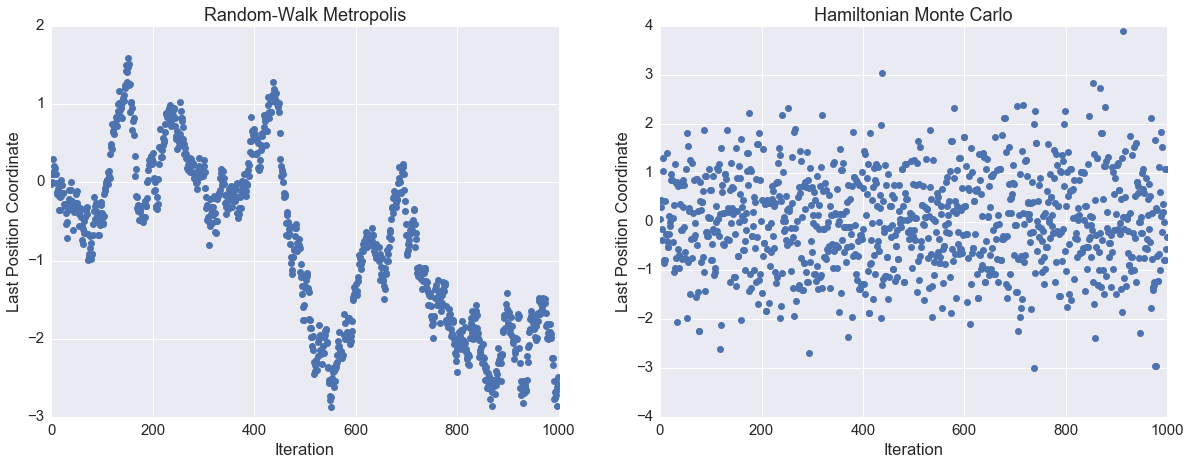

In [18]:
f, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,7))

#Metropolis - note the high autocorrelation even with 150 thinning steps
#Small stepsize required because dimension is so high
ax[0].plot(range(1000),mh_output_100d[:,99],'o')
ax[0].set_title('Random-Walk Metropolis')
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("Last Position Coordinate")

#HMC - Covers the space very well, with apparently independent draws
ax[1].plot(range(1000),hmc_output_100d[:,99],'o')
ax[1].set_title('Hamiltonian Monte Carlo')
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("Last Position Coordinate")
plt.savefig("100d_iterations.png")

**Plotting all means and standard deviations**

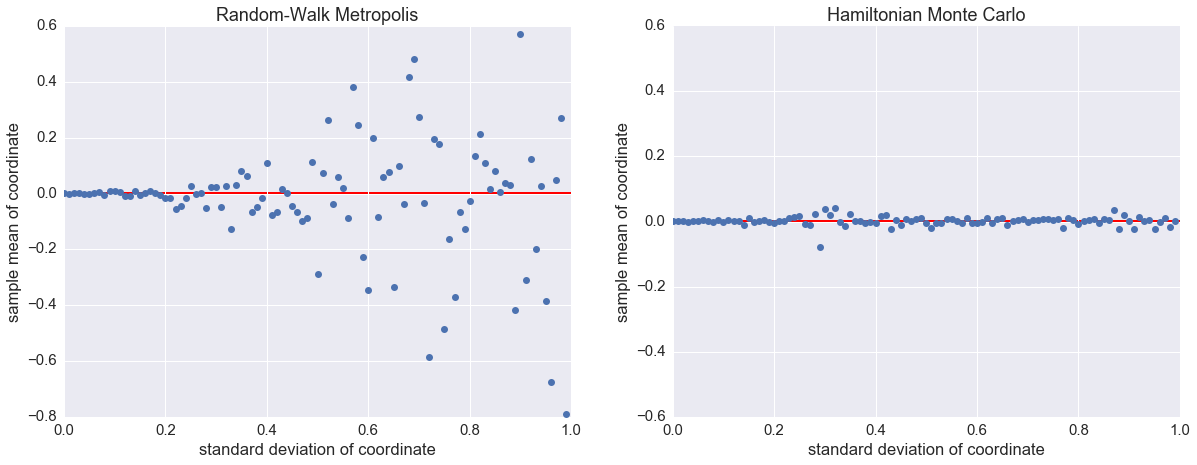

In [19]:
#All the means should be zero
f, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,7))

#Metropolis means - unstable in higher dimensions
ax[0].plot([i/100 for i in range(len(mh_means))],mh_means,'o')
ax[0].set_title('Random-Walk Metropolis')
ax[0].set_xlabel("standard deviation of coordinate")
ax[0].set_ylabel("sample mean of coordinate")
ax[0].axhline(y=0.001,xmin=0,xmax=100,c="red",linewidth=2,zorder=0)

#HMC means stay close to zero for all variables
ax[1].set_title('Hamiltonian Monte Carlo')
ax[1].plot([i/100 for i in range(len(hmc_means))],hmc_means,'o')
ax[1].axhline(y=0.001,xmin=0,xmax=100,c="red",linewidth=2,zorder=0)
ax[1].set_xlabel("standard deviation of coordinate")
ax[1].set_ylabel("sample mean of coordinate")
ax[1].set_ylim((-.6,.6))

plt.savefig("100d_means.png")

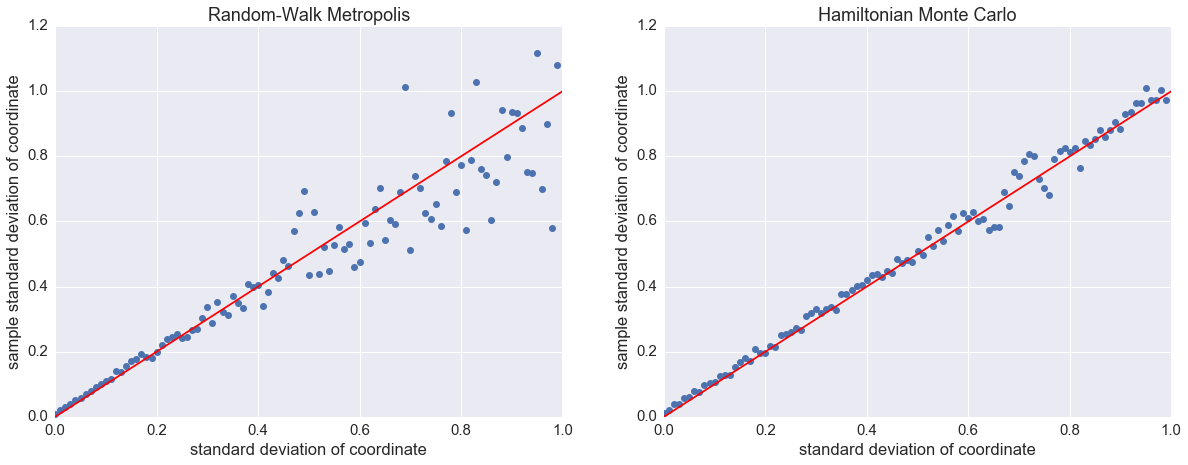

In [20]:
#Standard deviations should lie on the line y = x
f, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,7))

#Metropolis standard deviations do not follow expected value in higher dimensions
ax[0].set_title('Random-Walk Metropolis')
ax[0].plot([i/100 for i in range(len(mh_sds))],mh_sds,'o')
ax[0].plot([0,1],[0,1],'r-')
ax[0].set_xlabel("standard deviation of coordinate")
ax[0].set_ylabel("sample standard deviation of coordinate")

#HMC output standard deviations follow the line more closely in higher dimensions
ax[1].set_title('Hamiltonian Monte Carlo')
ax[1].plot([i/100 for i in range(len(hmc_sds))],hmc_sds,'o')
ax[1].plot([0,1],[0,1],'r-')
ax[1].set_xlabel("standard deviation of coordinate")
ax[1].set_ylabel("sample standard deviation of coordinate")

plt.savefig("100d_sds.png")

# Real Data Example - Cars Dataset

In [7]:
cars = pd.read_table('cars.txt',  delimiter=' ')
n = cars.shape[0]

#Get the data, create the design matrix
carX = np.vstack((np.repeat(1,n),np.array(cars.ix[:,0]))).T
carY = np.array(cars.ix[:,1]).reshape(n,1)

**Leapfrog and energy/gradient functions for the real data example**

In [8]:
def leapfrog_real(U, grad_U, current_q, X, Y, hyperparams, stepsize=0.25, steps=25):
    '''
    Performs the leapfrog algorithm for HMC, with 1 accept/reject step
    This is specifically for the real-data example with regression, as it includes the hyperparameters
    '''
    a = hyperparams[0]
    b = hyperparams[1]
    tau = hyperparams[2]
    
    q = current_q
    p = np.random.normal(0,1,q.size) # independent statndard normal variates
    current_p = p
    q_list=q
    p_list=p
    
    # Half step for momentum at the beginning
    
    p = p - stepsize*grad_U(q,X,Y,hyperparams)/2
    
    # Alternate full steps for position and momentum
    for i in range(steps):
        
        # Make a full step for the position
        
        q = q + stepsize*p
        q_list = np.vstack((q_list,q))
        
        # Make a full step for the momentum, except at end of trajectory
        if (i!=steps-1):
            p = p - stepsize*grad_U(q,X,Y,hyperparams)
            p_list = np.vstack((p_list,p))
    
    # Make a half step for momentum at the end
    p = p - stepsize*grad_U(q,X,Y,hyperparams)/2
    
    p_list = np.vstack((p_list,p))
    
    # Negate momentum at end of trajectory to make the proposal symmetric
    p = -p
    
    # Evaluate potential and kinetic energies at start and end of trajectory
    current_U = U(current_q,X,Y,hyperparams)
    current_K = sum(current_p**2)/2
    proposed_U = U(q,X,Y,hyperparams)
    proposed_K = sum(p**2)/2

    if(np.random.uniform(0,1) < np.exp(current_U-proposed_U+current_K-proposed_K)):
        return(q,p_list,q_list) # Accept
    else:
        return(current_q,p_list,q_list) # Reject
    

In [9]:
def U_real(theta,X,Y,hyperparams):
    """
    Energy for real data example - b_p-dim regression
    Only does Beta
    """
    
    beta = theta.reshape((2,1))
    a = hyperparams[0]
    b = hyperparams[1]
    tau = hyperparams[2]
    phi = hyperparams[3]
    
    b_p = beta.shape[0]
    return((-n/2 - a + 1)*np.log(phi) + phi*b + 1/2*(beta.T @ (phi*X.T @ X + tau*np.eye(b_p)) @ beta - 2*phi*Y.T @ X @ beta + phi*Y.T @ Y))

def U_grad_real(theta,X,Y,hyperparams):
    """
    Gradient for real data example - regression
    """
    beta = theta.reshape((2,1))
    a = hyperparams[0]
    b = hyperparams[1]
    tau = hyperparams[2]
    phi = hyperparams[3]
    
    b_p = beta.shape[0]
    phi_part = (-n/2 - a + 1)/phi + b + 1/2*(beta.T @ (X.T @ X) @ beta - 2*Y.T @ X @ beta + Y.T @ Y) #Doesn't use this currently
    beta_part = beta.T @ (phi*X.T @ X + tau*np.eye(b_p)) - phi*Y.T @ X
    #return(np.append(phi_part,beta_part))
    return(beta_part[0])

In [10]:
def HMC_real(U, grad_U, current_q,X,Y, hyperparams, stepsize=0.2, steps=25, max_iter= 20, step_range=0):
    '''
    Performs max_iter iterations of HMC with leapfrog discritization method
    To randomize stepsize, set step_range to be nonzero
    '''
    
    current_q_list = current_q
    
    for i in range(max_iter):
        
        #Randomize stepsize if called for
        #Note if step_range = 0, it just draws stepsize
        stepsize_r = np.random.uniform(stepsize-step_range,stepsize+step_range)

        #Keep the position variable after every itertion
        current_q,p_list,q_list = leapfrog_real(U, grad_U, current_q, X,Y,hyperparams, stepsize_r, steps)
        current_q_list = np.vstack((current_q_list,current_q))
    return(current_q_list[:-1,:])

**Running the HMC function**

In [11]:
#Input parameters
current_q = np.array([0,0])
car_hyperparams = np.array([.001,.001,.001,1/15**2])

hmc_output_real=HMC_real(U_real, U_grad_real, current_q, carX,carY, car_hyperparams, stepsize=0.1, steps=100, max_iter=1000)

**Plotting iterations**

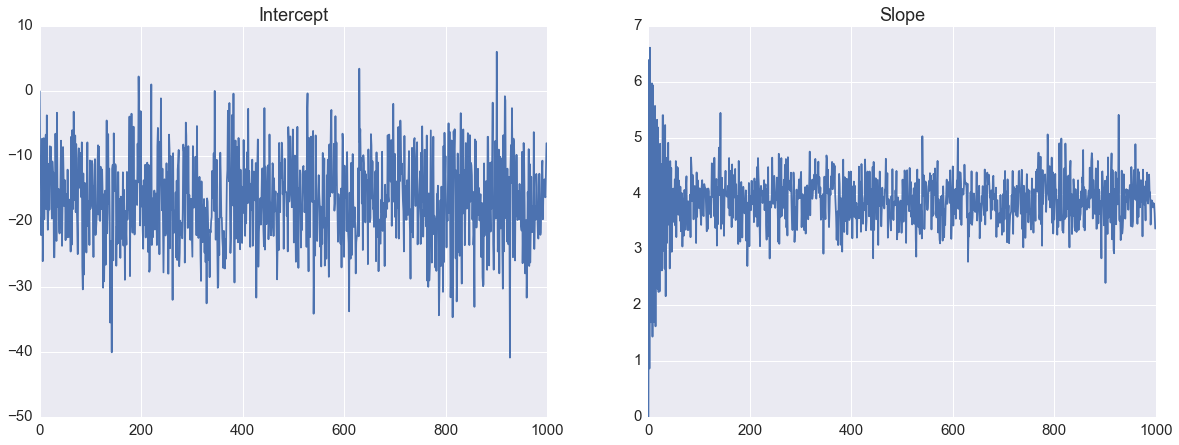

In [12]:
plt.figure(figsize=(20,7))

plt.subplot(121)
plt.plot(range(1000),hmc_output_real[:,0])
plt.title('Intercept')

plt.subplot(122)
plt.plot(range(1000),hmc_output_real[:,1])
plt.title('Slope')

plt.savefig("hmc_betas.png")

**Running frequentist regression and comparing**

In [13]:
mod = linear_model.LinearRegression(fit_intercept = True)
speed = cars["speed"]
dist = cars["dist"]

speed = speed.reshape(n, 1)
dist = dist.reshape(n, 1)

mod_fit = mod.fit(speed,dist)

#Getting the intercept and slope for the frequentist regression
reg_int = mod_fit.intercept_
reg_slope = mod_fit.coef_

/Users/Jake/anaconda/envs/snakes/lib/python3.5/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


/Users/Jake/anaconda/envs/snakes/lib/python3.5/site-packages/ipykernel/__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


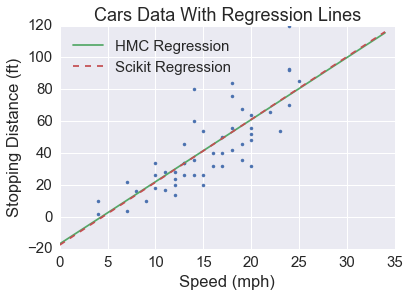

In [14]:
#Trimming the burn-in
intercept = np.mean(hmc_output_real[200:,0])
slope = np.mean(hmc_output_real[200:,1])

#Real data
x = carX[:,1]
y = np.array(carY)

xrange = range(max(x) + 10)
hmc_yrange = intercept + slope*xrange
reg_yrange = reg_int +reg_slope*xrange

#Plotting 
plt.figure(figsize=(20,7))

plt.plot(x,y, '.')
plt.plot(xrange,hmc_yrange,'-', label = "HMC Regression")
plt.plot(xrange,reg_yrange[0],'--',label ="Scikit Regression")
plt.title("Cars Data With Regression Lines")
plt.xlabel("Speed (mph)")
plt.ylabel("Stopping Distance (ft)")
plt.legend(loc = 'best')

plt.savefig("hmc_regression.png")

# HMC variation:  "Windows" of opportunity

In [15]:
def window_HMC(U, grad_U, Sigma, q, stepsize=0.2, steps=25, max_iter= 20, step_range=0):
    """
    Windowed HMC algorithm for higher acceptance ratio
    """
    
    window = random.randint(1,steps+1)
    direction = 2*np.random.binomial(1,0.5)-1
    offset = random.randint(0,window-1)
    q_output = q
    p = np.random.normal(0,1,q.size) # independent statndard normal variates
    
    for i in range(max_iter):
        #backward leapfrog
        stepsize = -stepsize*direction
        stepsize_r = np.random.uniform(stepsize-step_range,stepsize+step_range)
        p_list,q_list = window_leapfrog(U, grad_U, q, p, Sigma, stepsize_r, offset)
        
        #forward leapfrog
        stepsize = stepsize*direction
        stepsize_r = np.random.uniform(stepsize-step_range,stepsize+step_range)
        p_f_list,q_f_list = window_leapfrog(U, grad_U, q, p, Sigma, stepsize_r, steps = steps-offset)
        
        #merge the lists(1st element of the list is the -k th element in the algorithm)
        p_list,q_list = np.vstack((p_list[::-1],p_f_list[1:])), np.vstack((q_list[::-1],q_f_list[1:]))

        #define the windows
        p_reject_window, q_reject_window = p_list[0:window,],q_list[0:window,]
        p_accept_window, q_accept_window = p_list[::-1][0:window,],q_list[::-1][0:window,]
    
        # window energy calculation
        p_reject,q_reject,energy_reject = window_energy(U,Sigma,p_reject_window,q_reject_window)
        p_accept,q_accept,energy_accept = window_energy(U,Sigma,p_accept_window,q_accept_window)
    
        if(np.random.uniform(0,1)<(energy_accept-energy_reject)):
            p, q = p_accept,q_accept
        else:
            p,q = p_reject, q_reject
        
        q_output = np.vstack((q_output,q))
        
    return(q_output)

In [16]:
def window_leapfrog(U,grad_U, q, p, Sigma, stepsize, steps):
    '''
    Windowed leapfrog -similar to leapfrog, but tuned for the window ie omit acceptance-rejection step
    '''
    q_list = q
    p_list = p
    
    # Half step for momentum at the beginning
    p = p - stepsize*grad_U(q,Sigma)/2
    
    # Alternate full steps for position and momentum
    for i in range(steps):
        
        # Make a full step for the position
        q = q + stepsize*p
        q_list = np.vstack((q_list,q))
        
        # Make a full step for the momentum, except at end of trajectory
        if (i!=steps-1):
            p = p - stepsize*grad_U(q,Sigma)
            p_list = np.vstack((p_list,p))
    
    # Make a half step for momentum at the end
    p = p - stepsize*grad_U(q,Sigma)/2
    p_list = np.vstack((p_list,p))
    
    return (p_list,q_list)

In [17]:
from numpy import exp,log
 
def window_energy(U,Sigma,p_list,q_list):
    '''
    Calculates energy of a accept/reject window, cumulative of state_energy
    '''
    p0, q0 = p_list[0,],q_list[0,]
    for i in range(p_list.shape[0]):
        p, q = p_list[i,],q_list[i,]
        
        # The 1st step does not need the state energy calculation and accept/reject
        if (i!=0):
            p0,q0,energy = state_energy(U,Sigma,p0,q0,p,q,energy)
        else:
            energy = U(q,Sigma)+sum(p**2)/2
        
    return(p0,q0,energy)

def state_energy(U,Sigma,p0,q0,p,q,energy):
    '''
    Accept/reject the high probability point within a window
    Additionally does the state energy calculation for the cumulative window energy
    '''
    
    #energy of the new state
    Hamiltonian_energy = U(q,Sigma)+sum(p**2)/2
    #cumulative energy
    energy_new = -log(exp(-Hamiltonian_energy)+exp(-energy))
    
    #acceptance/ rejection within window
    a = exp(-energy+energy_new)
    b = exp(-Hamiltonian_energy+energy_new)
    if (np.random.uniform(0,1)<b/(a+b)):
        p0,q0 = p,q
        
    return(p0,q0,energy_new)

**Comparison for 2D gaussian**

In [45]:
Sigma2_high_cor = np.array([[1, 0.98],[0.98,1]])
current_q2 = np.array([-1.5,-1.55])
hmc_output_2d=HMC(U, grad_U, current_q2, Sigma2_high_cor, stepsize=0.18, steps=20, max_iter=200)
window_hmc_output_2d=window_HMC(U, grad_U, Sigma2_high_cor, current_q2, stepsize=0.18, steps=30, max_iter=200, step_range = 0)

While tuning the window HMC I noticed that the optimal stepsize is the same as that of the HMC however number of steps need to be larger, possibly becuase we partition the steps into several windows.

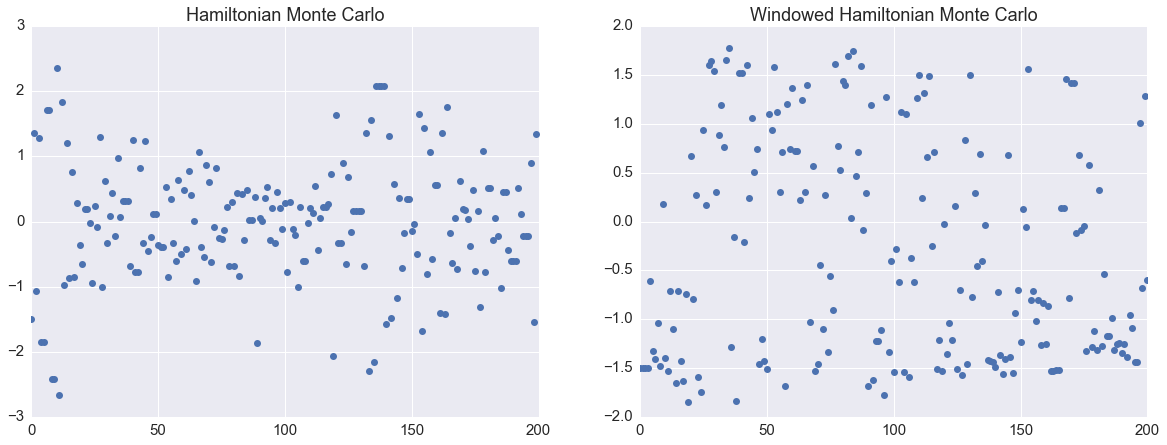

In [46]:
plt.figure(figsize=(20,7))

#HMC 2D Output from before
plt.subplot(121)
plt.plot(range(len(hmc_output_2d[:,0])),hmc_output_2d[:,0], 'o')
plt.title('Hamiltonian Monte Carlo')

#Windowed HMC - explores the space just as well
plt.subplot(122)
plt.title('Windowed Hamiltonian Monte Carlo')
plt.plot(range(len(window_hmc_output_2d[:,0])), window_hmc_output_2d[:,0], 'o')
plt.savefig("window_iter_2d.png")

**comparison in 10 dimension**

In [38]:
#Multivariate Normal distribution parameters
mu_10 = np.zeros(10)
cov_10 = np.diag([(i/10)**2 for i in range(1,11)])
#Running HMC - note random stepsize in the high-dimensional setting
current_q = np.random.random(10)
hmc_output_10d = HMC(U, grad_U, current_q, Sigma = cov_10, stepsize=0.13, steps=15, max_iter= 1000,step_range = 0.2*0.13)
#Running window_HMC
window_hmc_output_10d = window_HMC(U, grad_U, cov_10, current_q, stepsize=0.13, steps=20, max_iter= 1000,step_range = 0.2*0.13)

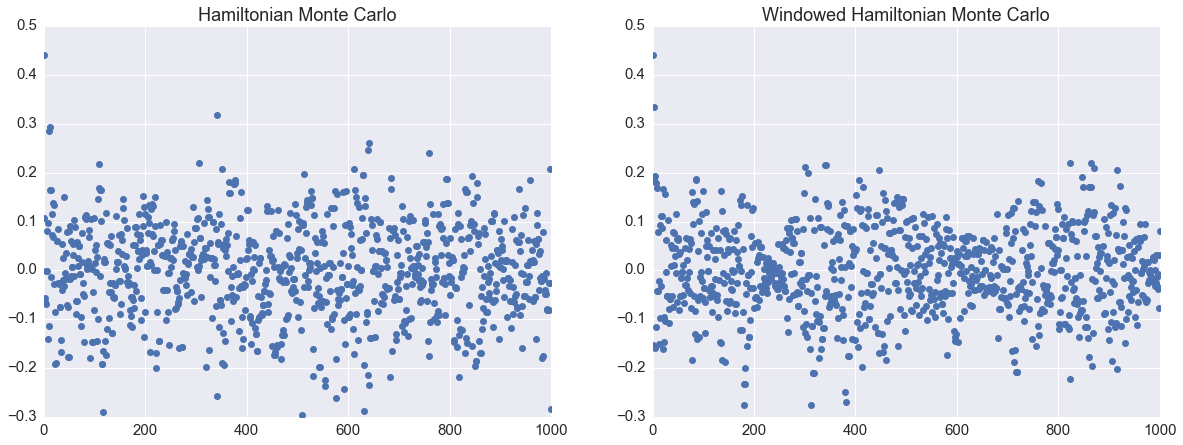

In [39]:
plt.figure(figsize=(20,7))

#Standard HMC output
plt.subplot(121)
plt.plot(range(len(hmc_output_10d[:,0])),hmc_output_10d[:,0], 'o')
plt.title('Hamiltonian Monte Carlo')

#Windowed HMC output
plt.subplot(122)
plt.title('Windowed Hamiltonian Monte Carlo')
plt.plot(range(len(window_hmc_output_10d[:,0])), window_hmc_output_10d[:,0], 'o')
plt.savefig("window_iter_10d.png")

**calculating Acceptance Ratio**

In [30]:
def accept_rate(output):
    """
    Calculates acceptance ration for any metropolis-like output
    """
    n = output.shape[0]
    count=0
    for i in range(n):
        if (i!=0):
            if ((output[i,]==output[(i-1),]).all()): #If the output is the same as previous, it was rejected
                count +=1
    reject_rate = count/(n-1)
    return(1-reject_rate)

In [40]:
window_hmc_10d_accept = accept_rate(window_hmc_output_10d)
hmc_10d_accept = accept_rate(hmc_output_10d)
window_hmc_10d_accept,hmc_10d_accept

(0.885, 0.8668668668668669)

Gets even better in higher dimensions.

# Parallelize

In [47]:
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
import time

**2 Dimension Case**

In [48]:
def window_parallel(current_q2):
    '''
    Wrapper function for parallel chains
    '''
    Sigma2_high_cor = np.array([[1, 0.98],[0.98,1]])
    return(window_HMC(U, grad_U, Sigma2_high_cor, current_q2, stepsize=0.18, steps=30, max_iter=1000, step_range = 0))

**Running Windowed HMC with parallel chains**

In [49]:
a = datetime.datetime.now()
chains = 10
starting_pts = np.random.random((2,chains))
with ProcessPoolExecutor(max_workers=4) as pool:
    res_2d = pool.map(window_parallel, [starting_pts[:,i] for i in range(chains)])

A = list(res_2d)
b = datetime.datetime.now()
parallel_time = b-a
print("Parallel Time is: ", parallel_time)

Parallel Time is:  0:00:29.669305


**Running Windowed HMC consecutively**

In [50]:
a = datetime.datetime.now()
check_2d = []
Sigma2_high_cor = np.array([[1, 0.98],[0.98,1]])
for i in range(chains):
    check_2d.append(window_HMC(U, grad_U, Sigma2_high_cor, np.random.random(2), stepsize=0.18, steps=30, max_iter=1000, step_range = 0))
b = datetime.datetime.now()
non_par_time = b-a
print("Non-paralell time is", non_par_time)

Non-paralell time is 0:00:45.502437


In [51]:
print("Speedup =",non_par_time/parallel_time)

Speedup = 1.5336536194562023


**Plotting the first 5 chains**

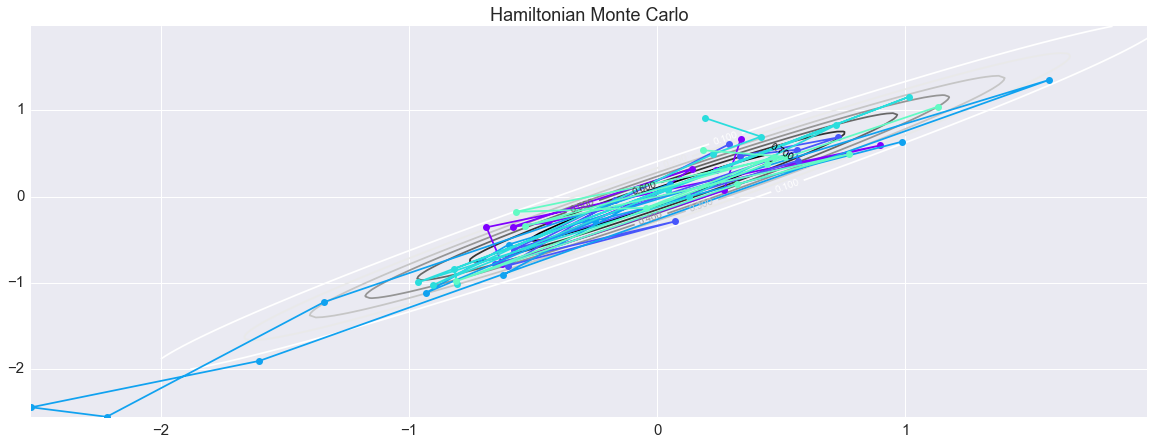

In [59]:
from matplotlib.pyplot import cm 
plt.figure(figsize=(20,7))


#PLotting only the first and last coordinate of each chain
delta = 0.025
x = np.arange(-2.0, 2.0, delta)
y = np.arange(-2.0, 2.0, delta)
X, Y = np.meshgrid(x, y)
Z = mlab.bivariate_normal(X, Y, 1.0, 1.0, 0.0, 0.0,0.98)
CS = plt.contour(X, Y, Z)
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Hamiltonian Monte Carlo')
color=cm.rainbow(np.linspace(0,1,chains))
for i,c in zip(range(5),color):
    plt.plot(A[i][::100,0], A[i][::100,1],'-o',c=c)

plt.savefig("WHMC_parallel.png")